In [1]:
import os,sys
sys.path.append('./hmvec-master/')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
from compute_power_spectra import *
from plotting import *
from params import *

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [38]:
ellMax = 9600
ells = np.arange(ellMax)
ellss = np.arange(6500)

mm = 2
mmm = 5000

nMs = 100
cmap1 = get_cmap(len(dictKey)+1)
#cmapsp = cycle(['#672766', '#a6228c', '#ed7625', '#1b988c', '#75bc43'])
#cmapsp = cycle(['#b974c6', '#510c5e', '#f96a35', '#96ca4f', '#f45523'])
#cmapsp = cycle(["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"])
#cmapsp = cycle(['#ea5545', '#f46a9b', '#ef9b20', '#edbf33', '#ede15b', '#bdcf32', '#87bc45', '#27aeef', '#b33dc6'])
cmapsp = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']

baseline = ghztoev(30)

ztype = [2., 6., 10.]
compute_noise = False


In [4]:
rscale = True

avtaulist = np.zeros((len(ztype), len(dictKey))) 
tauMWlist = np.zeros(len(dictKey))
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening, Screening2  = np.zeros((2, len(ztype), len(dictKey), 4, ellMax))
Survey_z6, Survey_z10 = np.zeros((2, len(dictKey), ellMax))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        nZs, zMin, zMax, rMin, rMax, mMin, mMax = chooseModel(MA, modelParams)
        nZs = int(nZs)
        zMax = min(ztest, zMax)

        data = import_data(MA, nZs, zMin, zMax, ellMax, rscale)
        if data==None:
            print(zMax, MA, rscale, ztest, ' skipped!')
            data = import_data_short(MA, nZs, zMin, zMax, ellMax, rscale)
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H = data
        else:
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        avtaulist[zind, mind]  = avtau/baseline
        dtaudzlist[zind, mind] = dtaudz/baseline
        tauMWlist[mind]        = probMW/baseline

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H

        CellTauTau[zind, mind] = avtaulist[zind, mind]**2. * (Cell1H + Cell2H)

        Screening[zind, mind]  = avtaulist[zind, mind]**2. * CMBDP
        Screening2[zind, mind] = avtaulist[zind, mind]**2. * CMBDP2

for mind, MA in enumerate(dictKey):
    Survey_z6[mind]  = avtaulist[1, mind]**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])
    Survey_z10[mind] = avtaulist[2, mind]**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])


In [5]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
            ellss = np.arange(6500)
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax
            ellss = np.arange(ellMax)            

        freqs = experiment['freqseV']
        leftoverdata = np.zeros((len(ztype), len(dictKey), len(freqs), 3, l0Max))
        for zind, ztest in enumerate(ztype):
            for mind, MA in enumerate(dictKey):
                epsilon = 1e-6
                recombination = lensedCMB
                screening = epsilon**4. * Screening[zind, mind]
                screening[np.isnan(screening)] = 0.
                weights = return_ILC_weights(ellss, l0Max, baseline, screening, recombination, experiment)
        np.save(weights_path(expname), weights)
    
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
            ellss = np.arange(6500)
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax
            ellss = np.arange(ellMax)

        leftoverdata = np.zeros((len(ztype), len(dictKey), 3, l0Max))
        for zind, ztest in enumerate(ztype):
            for mind, MA in enumerate(dictKey):
                epsilon = 1e-6
                recombination = lensedCMB
                screening = epsilon**4. * Screening[zind, mind]
                screening[np.isnan(screening)] = 0.
                leftoverdata[zind, mind] = get_ILC_noise(ellss, l0Max, baseline, screening, recombination, experiment)
        np.save(ILCnoisePS_path(expname), leftoverdata)


In [6]:
ms   = np.geomspace(mMin,mMax,nMs)          # masses
zs   = np.linspace(zMin,zMax,nZs)           # redshifts
ks   = np.geomspace(1e-4,1e3,10001)          # wavenumbers

print('Creating Halo Model.')
hcos = hm.HaloModel(zs, ks, ms, mass_function='tinker', mdef='vir')


Creating Halo Model.


In [7]:
print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Importing base CMB PS and adding T monopole.


In [8]:
masslist_old = dictKey
ff6 = interpolate.interp1d(masslist_old, avtaulist[1], kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2], kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist, kind='quadratic')
masslist = np.linspace(masslist_old[0], masslist_old[-1], 1000)


In [9]:
MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')


In [10]:
print(np.shape(avtaulist))

#np.save('./data/taubar_zmax6.npy', np.asarray([dictKey, avtaulist[1,:]]))
#np.save('./data/taubar_zmax10.npy', np.asarray([dictKey, avtaulist[2,:]]))

xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
yvals6 = ff6(masslist)+fftau(masslist)
yvals10 = ff10(masslist)+fftau(masslist)

#np.save('./data/interpTbar_zmax6.npy', np.asarray([masslist[:xarg], yvals6[:xarg]]))
#np.save('./data/interpTbar_zmax10.npy', np.asarray([masslist[:xarg], yvals10[:xarg]]))
#np.save('./data/interptaubar_zmax6.npy', np.asarray([masslist, ff6(masslist)]))
#np.save('./data/interptaubar_zmax10.npy', np.asarray([masslist, ff10(masslist)]))


(3, 20)


In [11]:
%run 'compute_power_spectra.py'

In [12]:
# test forecast
if True:
    mind = 10
    expname = 'Planck'

    ILCnoise = np.load(ILCnoisePS_path(expname))
    reconoise_z6  = np.load(reconoisePS_path(expname, 6))
    reconoise_z10  = np.load(reconoisePS_path(expname, 10))

    leftover_z6,  leftover_z10  = ILCnoise[1, mind, :, ells], ILCnoise[2, mind, :, ells]
    template_z6,  template_z10  = Survey_z6[mind, ells], Survey_z10[mind, ells]
    screening_z6, screening_z10 = Screening[1, mind, :, ells], Screening[2, mind, :, ells]
    screening_z6[np.isnan(screening_z6)] = 0.
    screening_z10[np.isnan(screening_z10)] = 0.

    sigmaFidMF1 = sigma_screening(0., mm, mmm, screening_z6, leftover_z6)
    sigmaFidMF2 = sigma_screening(0., mm, mmm, screening_z10, leftover_z10)

    sigmaFidMF3 = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z6, leftover_z6, template_z6)
    sigmaFidMF4 = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z10, leftover_z10, template_z10)

    sigmaFidMF5 = sigma_recoVtemplate(0., mm, mmm, template_z6[ellss], reconoise_z6[ellss], template_z6[ellss])
    sigmaFidMF6 = sigma_recoVtemplate(0., mm, mmm, template_z10[ellss], reconoise_z10[ellss], template_z10[ellss])

    print(sigmaFidMF1, sigmaFidMF2)
    print(sigmaFidMF3, sigmaFidMF4)
    print(sigmaFidMF5, sigmaFidMF6)


7.755977794499899e-09 7.755977794499899e-09
1.4403976258189638e-09 1.4403976258189638e-09
2.0623823356720947e-06 2.0623823356720947e-06


In [13]:
sigmaEpsilonList = np.ones((2, len(dictKey), 2, 3)) # (#reionization start, #masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='CMBHD': continue

        mm = 2
        mmm = 5000

        ILCnoise = np.load(ILCnoisePS_path(expname))
        reconoise_z6 = np.load(reconoisePS_path(expname, 6))
        reconoise_z10 = np.load(reconoisePS_path(expname, 10))

        leftover_z6 = ILCnoise[1, mind, :, ells]
        leftover_z10 = ILCnoise[2, mind, :, ells]

        screening_z6 = Screening[1, mind, :, ells]
      #  screening_z6 = Screening2[1, mind, :, ells]
        screening_z10 = Screening[2, mind, :, ells]
      #  screening_z10 = Screening2[2, mind, :, ells]
        screening_z6[np.isnan(screening_z6)] = 0.
        screening_z10[np.isnan(screening_z10)] = 0.

        template_z6 = Survey_z6[mind, ells]
        template_z10 = Survey_z10[mind, ells]

        # get constraint with different covariant matrices
        # first constraint: CMB screening
        sigmaEpsilonList[0, mind, eind, 0] = sigma_screening(0., mm, mmm, screening_z6, leftover_z6)
        sigmaEpsilonList[1, mind, eind, 0] = sigma_screening(0., mm, mmm, screening_z10, leftover_z10)    

        # Third constraint: CMB screening cross correlated wih template
        sigmaEpsilonList[0, mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z6, leftover_z6, template_z6)
        sigmaEpsilonList[1, mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z10, leftover_z10, template_z10)

        # third constraint: template cross correlated with reconstruction
        if expname!='Planck':
            sigmaEpsilonList[0, mind, eind, 2] = sigma_recoVtemplate(0., mm, mmm, template_z6[ellss], reconoise_z6[ellss], template_z6[ellss])
            sigmaEpsilonList[1, mind, eind, 2] = sigma_recoVtemplate(0., mm, mmm, template_z10[ellss], reconoise_z10[ellss], template_z10[ellss])

    if mind==0:
        sigmaEpsilonList[:, mind, :, :] = 1e-4
    if mind==len(dictKey)-1:
        sigmaEpsilonList[:, mind, :, :] = 1e-4

/home/dpirvu/DarkPhoton/compute_power_spectra.py:375: RuntimeWarning: divide by zero encountered in double_scalars
  return (0.398942*(np.sum(TrF[ellmin:])**(-0.5))**0.5)**0.5


## Plots

[1e-13, 1e-12, 1e-11]
['$2{\\times}10^{-13}$', '$10^{-12}$', '$6{\\times}10^{-12}$']


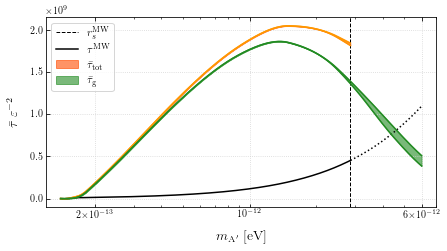

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
plt.axvline(MAMW_rscalelimit, ls='--', color='k', alpha=1, linewidth=1, label=r'$r_{s}^{\rm MW}$')
plt.grid(ls=':', color='lightgray', alpha=1)

xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
plt.plot(masslist[:xarg], fftau(masslist)[:xarg], color='k', ls='-', label=r'$\tau^{\rm MW}$')
plt.plot(masslist[xarg:], fftau(masslist)[xarg:], color='k', ls=':')

plt.fill_between(masslist[:xarg], yvals6[:xarg], yvals10[:xarg], color=cmap1(1), alpha=0.6, label=r'$\bar{\tau}_{\rm tot}$')
plt.plot(masslist[:xarg], yvals6[:xarg], color=cmap1(2), ls='-')
plt.plot(masslist[:xarg], yvals10[:xarg], color=cmap1(2), ls='-')
#plt.fill_between(masslist[xarg:], yvals6[xarg:], yvals10[xarg:], color=cmap1(1), alpha=0.1)

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color='forestgreen', alpha=0.6, label=r'$\bar{\tau}_{\rm g}$')
plt.plot(masslist, ff6(masslist), color='forestgreen', ls='-')
plt.plot(masslist, ff10(masslist), color='forestgreen', ls='-')

plt.ylabel(r'$\bar{\tau} \; \varepsilon^{-2}$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.set_xscale('log')

a=ax.get_xticks().tolist()[1:-1]
print(a)
a[0]=2e-13
a[-1]=6e-12
ax.set_xticks(a)
a=[fmt(al) for al in a]
print(a)
ax.set_xticklabels(a)
plt.xlim((1.2e-13, 7e-12))

#plt.yscale('log')
plt.legend(loc=2)
plt.savefig('./plots/monopoles.pdf', rasterize=True)
plt.show()

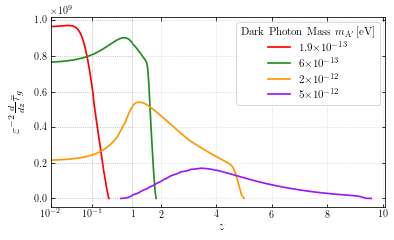

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
divider = make_axes_locatable(ax)
axLin = divider.append_axes("right", size=3.5, pad=0)#, sharey=ax)

xcap = 1
cych = cycle([cmap1(0), 'forestgreen', cmap1(2), cmapsp[4]])

ax.grid(ls=':', color='darkgray', alpha=1)
axLin.grid(ls=':', color='darkgray', alpha=0.5)
ax.axvline(xcap, ls='-', color='darkgray', alpha=0.5)

for mind, MA in enumerate(dictKey):
    if mind==0: continue
    elif mind%5==0 or mind==18:
        iind = next(cych)
        zs1 = zsList[1, mind]
        zs2 = zsList[2, mind]
        dat1 = dtaudzlist[1, mind]
        dat2 = dtaudzlist[2, mind]

        zsold = np.concatenate((zs1[zs1<=6.], zs2[zs2>6.]))
        dataold = np.concatenate((dat1[zs1<=6.], dat2[zs2>6.]))
        fint = interpolate.interp1d(zsold, dataold, kind='linear')
        zsnew = np.linspace(zsold[0], zsold[-1], 10000)

        lab2 = r'{}'.format(fmt(MA))
        lss = '-'

        ax.plot(zsnew[(zsnew<=xcap)&(fint(zsnew)>0)], fint(zsnew)[(zsnew<=xcap)&(fint(zsnew)>0)], color=iind, ls=lss, linewidth=1.7)
        axLin.plot(zsnew[(zsnew>=xcap)&(fint(zsnew)>0)], fint(zsnew)[(zsnew>=xcap)&(fint(zsnew)>0)], color=iind, label=lab2, ls=lss, linewidth=1.7)

        #annot_max(zsnew[indmax], f(zsnew)[indmax], lab, iind, xcap, mind, \
        #ax=(ax if zsnew[indmax]<xcap else axLin))
#labelLines(ax.get_lines(), align=False, xvals=np.geomspace(0.01, xcap, ct1))
#labelLines(axLin.get_lines(), align=False, xvals=np.linspace(xcap+1, 10, ct2))
ax.set_ylabel(r'$\varepsilon^{-2} \frac{d}{d z} \bar{\tau}_g$')
axLin.set_xlabel(r'$z$')

plt.setp(axLin.get_xticklabels(), visible=True)
plt.setp(ax.get_yticklabels(), visible=True)
axLin.xaxis.set_label_coords(0.35, -.07)

ytickslocs = ax.get_yticks()
axLin.axes.yaxis.set_ticklabels([])
axLin.axes.get_yaxis().set_ticks(ytickslocs)
ymin, ymax = ax.get_ylim()
axLin.set_ylim((ymin, ymax))

axLin.legend(ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.set_xlim((0.01, int(xcap))); axLin.set_xlim((int(xcap), 10.1)); ax.set_xscale('log'); axLin.set_xscale('linear')
ax.spines['right'].set_visible(False); axLin.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('left'); axLin.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('both'); axLin.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in"); axLin.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in"); axLin.tick_params(which='both', axis="x", direction="in")

a=ax.get_xticks().tolist()[:3]
a[0]=1e-2
a[1]=1e-1
a[2]=1
ax.set_xticks(a)
ax.set_xticklabels([fmt(al) for al in a])

plt.savefig('./plots/dtaudz.pdf', rasterize=True); plt.show()


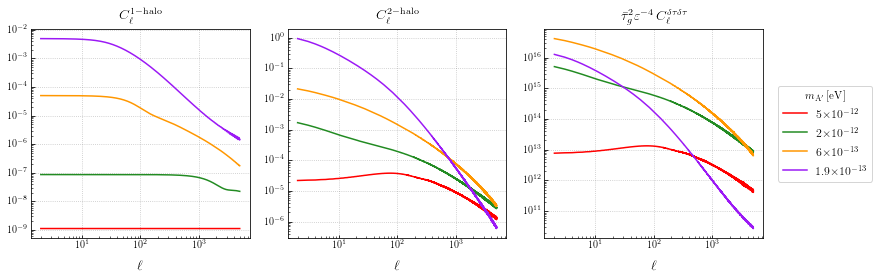

In [41]:
fig = plt.figure(figsize=(12, 3.5))
gs = GridSpec(1, 10, figure=fig)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[0, 6:9])
ax4 = fig.add_subplot(gs[0, 9:])
ax = [ax1, ax2, ax3, ax4]

label_list = [r'$C_\ell^{1-{\rm halo}}$',\
              r'$C_\ell^{2-{\rm halo}}$',\
              r'$C_\ell^{\delta\tau\delta\tau}$']
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
cych = cycle([cmap1(0), 'forestgreen', cmap1(2), cmapsp[4]])

for mind, MA in reversed(list(enumerate(dictKey))):
    if mind==0: continue
    elif mind%5==0 or mind==18:
        iind = next(cych)
        lab1 = r'{}'.format(fmt(MA))

        #ax[0].fill_between(ells[mm:mmm], preqs*(Cell1Hdata[1, mind, mm:mmm]), preqs*(Cell1Hdata[2, mind, mm:mmm]), alpha=1, color=iind)
        ax[0].plot(ells[mm:mmm], preqs*(Cell1Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
        #ax[1].fill_between(ells[mm:mmm], preqs*(Cell2Hdata[1, mind, mm:mmm]), preqs*(Cell2Hdata[2, mind, mm:mmm]), alpha=1, color=iind)
        ax[1].plot(ells[mm:mmm], preqs*(Cell2Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
        #ax[2].fill_between(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]), preqs*(CellTauTau[2, mind, mm:mmm]), alpha=1, color=iind)
        ax[2].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]), alpha=1, color=iind)
        #ax[3].fill_between(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]), preqs*(CellTauTau[2, mind, mm:mmm]), alpha=1, color=iind, label=lab1)
        ax[3].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]), alpha=1, color=iind, label=lab1)

#ax[3].legend(fontsize=12, loc='center', ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[3].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[3].set_xscale('log', subsx=[]); ax[3].set_yscale('log', subsy=[])
ax[3].spines['right'].set_visible(False); ax[3].spines['left'].set_visible(False)
ax[3].spines['top'].set_visible(False); ax[3].spines['bottom'].set_visible(False)
ax[3].axes.yaxis.set_ticklabels([]); ax[3].axes.xaxis.set_ticklabels([])
ax[3].set_ylim((1.1e50, 2e50)); ax[3].set_xlim((1.1e50, 2e50))

for aa, axx in enumerate(ax[:-1]):
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_title((r'$\bar{\tau}_g^2 \varepsilon^{-4} \,$' if aa==2 else ' ')+label_list[aa])
    axx.set_xscale('log'); axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
  #  axx.xaxis.set_label_coords(1.015, -0.015)
  #  axx.xaxis.set_label_coords(0, -0.015)
plt.savefig('./plots/celltautau.pdf', rasterize=True)
plt.show()


/tmp/ipykernel_8248/2153402482.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


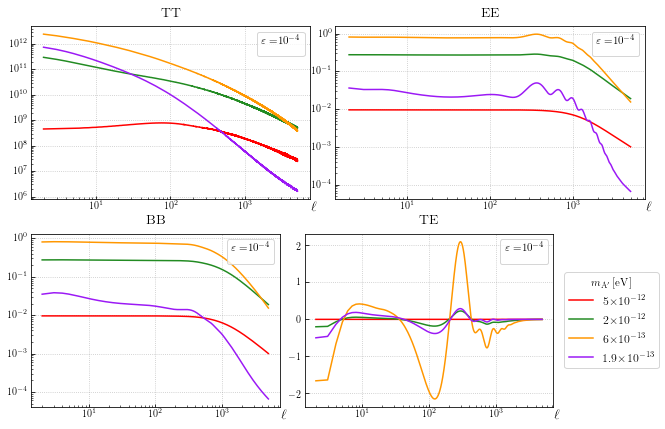

In [42]:
fig = plt.figure(figsize=(11, 7))
gs = GridSpec(2, 21, figure=fig)
ax1 = fig.add_subplot(gs[0, :10])
ax2 = fig.add_subplot(gs[0, 10:])
ax3 = fig.add_subplot(gs[1, :9])
ax4 = fig.add_subplot(gs[1, 9:18])
ax5 = fig.add_subplot(gs[1, 18:])
ax = [ax1, ax2, ax3, ax4, ax5]

ylabel_list = [r'$C_{\ell}^{TT, \; {\rm rec}}$',r'$C_{\ell}^{EE, \; {\rm rec}}$',\
               r'$C_{\ell}^{BB, \; {\rm rec}}$',r'$C_{\ell}^{TE, \; {\rm rec}}$']
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.subplots_adjust(hspace=.2)
plt.subplots_adjust(wspace=4.5)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
cych = cycle([cmap1(0), 'forestgreen', cmap1(2), cmapsp[4]])

for mind, MA in reversed(list(enumerate(dictKey))):
    if mind==0: continue
    elif mind%5==0 or mind==18:
        iind = next(cych)
        for ii in range(len(Screening[zind, mind])):
            epstest = 1e-4
            #ax[ii].fill_between(ells[mm:mmm], preqs*Screening[1, mind, ii, mm:mmm], preqs*Screening[2, mind, ii, mm:mmm], color=iind)
            ax[ii].plot(ells[mm:mmm], preqs*epstest**4.*Screening[1, mind, ii, mm:mmm], color=iind)
            if ii==0:
               # lab1 = r'${}$'.format(int(MA/1e-13))
                lab1 = r'${}$'.format(fmt(MA))
                #ax[4].fill_between(ells[mm:mmm], preqs*Screening[1, mind, ii, mm:mmm], preqs*Screening[2, mind, ii, mm:mmm], color=iind, label=lab1)
                ax[4].plot(ells[mm:mmm], preqs*epstest**4.*Screening[1, mind, ii, mm:mmm], color=iind, label=lab1)
            ax[ii].legend(title=r'$\varepsilon=$'+str(fmt(epstest)), loc=1)

#ax[4].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [10^{-13}{\rm eV}]$')
ax[4].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[4].set_xscale('log', subsx=[]); ax[4].set_yscale('log', subsy=[])
ax[4].spines['right'].set_visible(False); ax[4].spines['left'].set_visible(False)
ax[4].spines['top'].set_visible(False); ax[4].spines['bottom'].set_visible(False)
ax[4].axes.yaxis.set_ticklabels([]); ax[4].axes.xaxis.set_ticklabels([])
ax[4].set_ylim((1.1e50, 2e50)); ax[4].set_xlim((1.1e50, 2e50))

for aa, axx in enumerate(ax[:-1]):
    axx.set_title([r'\rm TT', r'\rm EE', r'\rm BB', r'\rm TE'][aa])
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
   # axx.legend(title=r'$\epsilon^{-4} \bar{\tau}_g^2 \sum C_{\ell}^{\delta\tau\delta\tau} $'+ylabel_list[aa], loc=[3,3,3,2][aa])
    axx.set_xscale(('log'))# if aa!=3 else 'linear'))
    axx.set_yscale(('log' if aa!=3 else 'linear'))
    axx.grid(ls=':', color='gray', alpha=0.5)
    axx.xaxis.set_label_coords(1.015, -0.015)
plt.savefig('./plots/screeningPS.pdf', rasterize=True)
plt.show()


In [43]:
%run 'params.py'

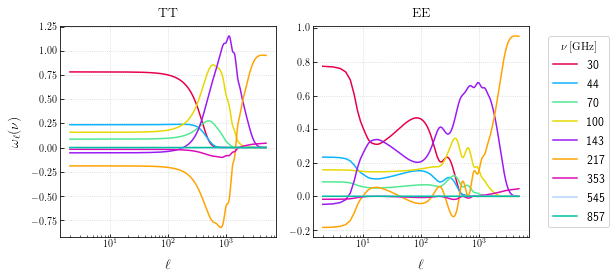

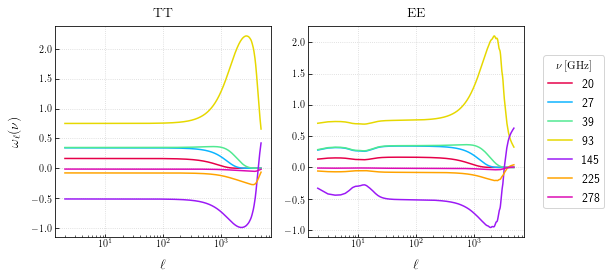

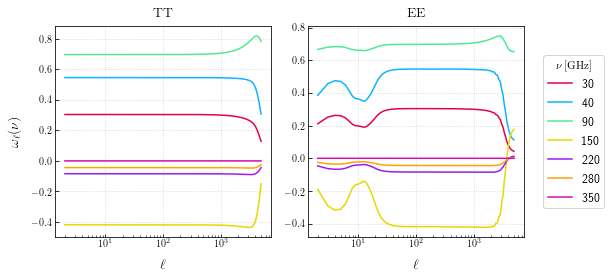

In [44]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):

    fig = plt.figure(figsize=(8, 3.5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)
    
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    mind = 7

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        #Nell  = noise(ells, experiment)
        ILCweights = np.load(weights_path(expname))
        cmapsp1 = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
        for jj in range(len(freqs)):
            labfreq = ('{}'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(ILCweights[ii, mm:mmm, jj]), color=cmapsp1[jj], label=labfreq)
    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1, title=r'$\nu \, [{\rm GHz}]$')
    ax[len(ax)-1].set_xscale('log', subsx=[]); ax[len(ax)-1].set_yscale('log', subsy=[])
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    ax[0].set_ylabel(r'$\omega_\ell(\nu)$')

    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
        if ai==0:
            ax.set_xscale('log')
        elif ai==1:
            ax.set_xscale('log')
        elif ai==2:
            ax.set_xscale('log')
      #  ax.xaxis.set_label_coords(1.015, -0.015)
        ax.grid(ls=':', color='darkgray', alpha=0.5)
    plt.savefig('./plots/weights'+str(expname)+'.pdf', rasterize=True)
    plt.show()

/home/dpirvu/DarkPhoton/compute_power_spectra.py:262: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:263: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)
No handles with labels found to put in legend.
/home/dpirvu/DarkPhoton/compute_power_spectra.py:262: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:263: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)
No handles with labels found to put in legend.
/home/dpirvu/DarkPhoton/compute_power_spectra.py:262: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:263: RuntimeWarning: overflow encountered in exp
  N

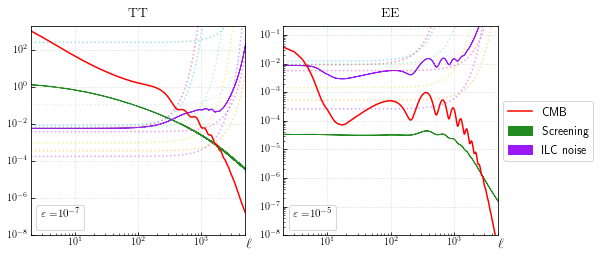

No handles with labels found to put in legend.
No handles with labels found to put in legend.


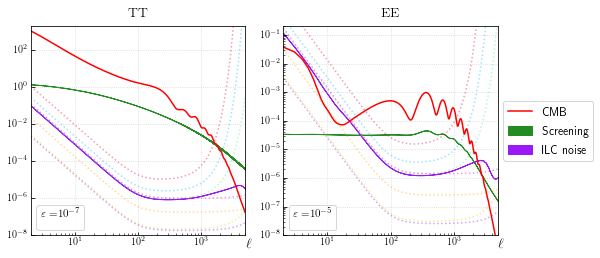

No handles with labels found to put in legend.
No handles with labels found to put in legend.


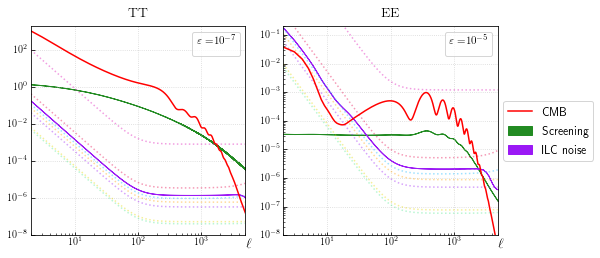

In [45]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):

    fig = plt.figure(figsize=(8, 3.5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    #plt.subplots_adjust(wspace=1)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    mind = 7
    cych = [cmap1(0), 'forestgreen', cmap1(2), cmapsp[4]]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        cmapsp1 = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
        for jj in range(len(freqs)):
            labfreq = ('{} GHz'.format(int(freqs[jj])) if ii==0 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cmapsp1[jj], alpha=0.4, ls=':')

        if ii==0:
            epsilon = 1e-7   # TT
        elif ii==1 or ii==3:
            epsilon = 1e-5    # EE, TE
        elif ii==2:
            epsilon = 4e-6      # BB
        
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], label=lab0)

        ax[ii].fill_between(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), \
                                          preqs*(epsilon**4. * Screening[2, mind, ij, mm:mmm]), \
                                                  color=cych[1], ls='-', alpha=1, label=lab2)

    #    ax[ii].fill_between(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij] - epsilon**4. * Screening[1, mind, ij, mm:mmm]), \
    #                                      preqs*(lensedCMB[mm:mmm, ij] - epsilon**4. * Screening[2, mind, ij, mm:mmm]), \
    #                        color=cych[2], ls='-', alpha=1, label=lab1)

        ILCnoise = np.load(ILCnoisePS_path(expname))
        ax[ii].fill_between(ells[mm:mmm], preqs*(ILCnoise[1, mind, ij, mm:mmm]), \
                                          preqs*(ILCnoise[2, mind, ij, mm:mmm]), color=cych[3], label=lab3)

        ax[ii].legend(title=r'$\varepsilon=$'+str(fmt(epsilon)))

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1)#, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[len(ax)-1].set_xscale('log', subsx=[]); ax[len(ax)-1].set_yscale('log', subsy=[])
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')
        
        #ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
        if ai==0:
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((1e-8,2000))
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim((1e-8,0.2))
            ax.set_xlim((mm,mmm))
        elif ai==2:
            ax.set_xscale('log')
            ax.set_yscale('log')
     #       ax.set_ylim((1e-8,5e-3))
            ax.set_xlim((mm,mmm))
        ax.xaxis.set_label_coords(1.015, -0.015)
        ax.grid(ls=':', color='darkgray', alpha=0.5)
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

#### Contour Plot

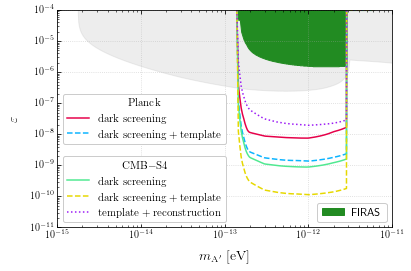

In [46]:
constraint = [r'$\rm dark \; screening$', \
              r'$\rm dark \; screening + template$', \
              r'$\rm template + reconstruction$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

cmap = get_cmap(14)
fig, ax = plt.subplots(1,1, figsize = (6,4))

masslist_old = dictKey
masslist = np.linspace(masslist_old[0], masslist_old[-1], 1000)
cmapsp = cycle(['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0'])

datashape = np.shape(sigmaEpsilonList)
for eind, (expname, experiment) in enumerate(zip([r'$\rm Planck$', r'$\rm CMB{-}S4$', r'$\rm CMB{-}HD$'], [Planck, CMBS4, CMBHD])):
    if eind==2: continue
    secondary_lines, secondary_labels = [], []
    
    for method in range(datashape[-1]):
        if eind==0 and method==2: continue
        
        col = next(cmapsp)
        lss = ['-', '--', ':'][method]

        ff = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[0, :, eind, method], kind='slinear')
        gf = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[1, :, eind, method], kind='slinear')
        xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
        list2plot1 = 1./ff(masslist); list2plot1[xarg:] = 1e-4
        list2plot2 = 1./gf(masslist); list2plot2[xarg:] = 1e-4

   #     plt.fill_between(masslist, list2plot1, list2plot2, color=col)
        l1, = plt.plot(masslist, list2plot1, color=col, ls=lss)
   #     plt.plot(masslist, list2plot2, color=col, ls=lss)

        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, fancybox=True, framealpha=1, loc=['center left',3][eind]))
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

xvals, firasz6 = np.load('./data/FIRAScontour_CL99_reio6.npy')
xvals, firasz10 = np.load('./data/FIRAScontour_CL99_reio10.npy')
xarg = np.argmin(np.abs(xvals-MAMW_rscalelimit))
firasz6[xarg:] = 1e-4
firasz10[xarg:] = 1e-4
plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), color='forestgreen', label=r'FIRAS')

#plt.axvline(MAMW_rscalelimit, ls='-', color='darkgray', label=r'$r_s^{\rm MW}$')
plt.legend(fancybox=True, framealpha=1, loc=4)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((1e-15, 1e-11))
plt.ylim((1e-11, 1e-4))
#plt.ylabel(r'$\sigma_{\varepsilon}$')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.savefig('./plots/contours.pdf', rasterize=True)
plt.show()


In [ ]:
constraint = [r'$\rm dark \; screening$', \
              r'$\rm dark \; screening + template$', \
              r'$\rm template + reconstruction$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

masslist_old = dictKey
masslist = np.linspace(masslist_old[0], masslist_old[-1], 1000)
cmapsp = cycle(['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0'])

for eind, (expname, experiment) in enumerate(zip([r'$\rm Planck$', r'$\rm CMB{-}S4$', r'$\rm CMB{-}HD$'], [Planck, CMBS4, CMBHD])):
    cmap = get_cmap(14)
    fig, ax = plt.subplots(1,1, figsize = (10,5))
    secondary_lines, secondary_labels = [], []
    
    for method in range(datashape[-1]):
        col = next(cmapsp)

        ff = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[0, :, eind, method], kind='slinear')
        gf = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[1, :, eind, method], kind='slinear')
        xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
        list2plot1 = 1./ff(masslist); list2plot1[xarg:] = 1e-4
        list2plot2 = 1./gf(masslist); list2plot2[xarg:] = 1e-4

        plt.fill_between(masslist, list2plot1, list2plot2, color=col, alpha=1)
        l1, = plt.plot(masslist, list2plot1, color=col)
        plt.plot(masslist, list2plot2, color=col)

        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, fancybox=True, framealpha=1, loc=4))
    plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

    xvals, firasz6 = np.load('./data/FIRAScontour_CL99_reio6.npy')
    xvals, firasz10 = np.load('./data/FIRAScontour_CL99_reio10.npy')
    xarg = np.argmin(np.abs(xvals-MAMW_rscalelimit))
    firasz6[xarg:] = 1e-4
    firasz10[xarg:] = 1e-4
    plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), linewidth=1, alpha=1, color='forestgreen', label=r'FIRAS')

    #plt.axvline(MAMW_rscalelimit, ls='-', color='darkgray', alpha=1, label=r'$r_s^{\rm MW}$')
    plt.legend(fancybox=True, framealpha=1, loc=3)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")

    plt.xlim((1e-14, 1e-10))
    plt.ylim((1e-11, 1e-4))
    plt.ylabel(r'$\sigma_{\varepsilon}$')
    plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
    plt.xscale('log')
    plt.yscale('log')

    plt.grid(ls=':', color='darkgray', alpha=0.5)
    #plt.savefig('./plots/contours.pdf', rasterize=True)
    plt.savefig('./plots/contours_noT0.pdf', rasterize=True)
    plt.show()
